#  Instrument variable

### Økonometri A (ØkA)

Bertel Schjerning

Department of Economics, University of Copenhagen


### Enable autoreload

In [1]:
# Sørger for at alle importerede python filer geninlæses ved import statements
# Nødvedigt, hvis ændinger skal tage effekt uden at genstarte Python Kernel
%load_ext autoreload
%autoreload 2

# Part 1: IV estimation (løn regression)

### Indlæs data og moduler

In [2]:
import pandas as pd
import numpy as np
import mymlr as mlr  

# Indlæs data og opret variabler
df_mroz = pd.read_stata("../data/mroz.dta")   # Indlæs data fra en Stata-fil
df_mroz['const'] = 1  # Tilføj en konstant term (intercept)
df_mroz['lwage'] = np.log(df_mroz['wage'])  # Logaritmer lønvariablen 'wage'
df = df_mroz.dropna(subset='lwage')  # Fjern rækker med manglende værdier i 'lwage'

### Sammenlign OLS og IV

In [3]:
# OLS
m_ols = mlr.ols(df[['const', 'educ']], df['lwage'])  # Estimér OLS-model

# IVE med 'motheduc' som instrument
m_2sls = mlr.tsls(y=df['lwage'], 
                  X1=df[['const']], 
                  X2=df[['educ']], 
                  Ze=df[['motheduc']])  

mlr.summary([m_ols, m_2sls], column_titles=["OLS", "IV"], report_stats="t")


                         OLS       IV
Dependent variable     lwage    lwage
             const   -0.1852   0.7022
                   (-0.9998) (1.3984)
              educ    0.1086   0.0385
                    (7.5451) (0.9742)
         R_squared    0.1179   0.0022
               TSS  223.3274 223.3274
               RSS  197.0010 222.8310
               ESS   26.3264   0.4964
                 n       428      428
Note: t-statistics are reported in parentheses.



### OLS/IV: Simpel implemtering med en forklarende variable og et instrument 

In [4]:
cov=df[['lwage','educ', 'motheduc']].cov()
b_OLS=cov.loc['lwage', 'motheduc']/cov.loc['educ','educ']
b_IV=cov.loc['lwage', 'motheduc']/cov.loc['educ', 'motheduc']
print(f'Covariance matrix\n {cov}\n')
print(f'b_OLS (educ) {b_OLS.round(4)}')
print(f'b_IV  (educ) {b_IV.round(4)}')
mlr.summary([m_ols, m_2sls], column_titles=["OLS", "IV"], report_stats="t")


Covariance matrix
              lwage      educ   motheduc
lwage     0.523015  0.567466   0.112796
educ      0.567466  5.222942   2.925967
motheduc  0.112796  2.925967  10.943526

b_OLS (educ) 0.0216
b_IV  (educ) 0.0385
                         OLS       IV
Dependent variable     lwage    lwage
             const   -0.1852   0.7022
                   (-0.9998) (1.3984)
              educ    0.1086   0.0385
                    (7.5451) (0.9742)
         R_squared    0.1179   0.0022
               TSS  223.3274 223.3274
               RSS  197.0010 222.8310
               ESS   26.3264   0.4964
                 n       428      428
Note: t-statistics are reported in parentheses.



### IV som effekten af $z$ på $y$ relativt til effekten af $z$ på $x$

In [5]:
# First stage (effekt af z på x)
m_first = mlr.ols(y=df['educ'], X=df[['const', 'motheduc']])  

# Reduceret form (effekt af z på y)
m_reduced = mlr.ols(y=df['lwage'], X=df[['const', 'motheduc']])  

b_2SLS=m_reduced['beta_hat'][1]/m_first['beta_hat'][1]
print(f'b_IV   (educ) {b_IV.round(4)}')
print(f'b_2SLS (educ) {b_2SLS[0].round(4)}')


b_IV   (educ) 0.0385
b_2SLS (educ) 0.0385


# Part 2: Estimation af model for consumer demand

Grieco, P.L., Murry, C. and Yurukoglu, A. (2024): "The evolution of market power in the us automobile industry."
<br>*The Quarterly Journal of Economics*, 139(2), pp.1201-1253.


## Modellering af Markedsandele: Logit Model

**Nyttefunktion for Forbruger $i$, Produkt $j$ i Marked $m$:**

$$
U_{imj} = \beta \mathbf{x}_{mj} - \alpha p_{mj} + \xi_{mj} + \epsilon_{imj}
$$

- $\mathbf{x}_{mj}$: Observerbare karakteristika for produkt $j$ i marked $m$ (f.eks. størrelse, kvalitet).
- $p_{mj}$: Pris for produkt $j$ i marked $m$.
- $\xi_{mj}$: Uobserverbare karakteristika (f.eks. brand, placering).
- $\epsilon_{imj}$: Idiosynkratisk fejlled, der følger en ekstremværdi fordeling (Gumbel).

**Markedsandel for Produkt $j$ i Marked $m$:**

Forbrugeren vælger produktet, der maksimerer nytte, hvilket giver beslutningsreglen:
$$
j_{im}^* = \arg \max_{j=0,1,\dots, J} U_{imj}
$$

**Markedsandele:**

I Økonometri B viser vi, at antagelsen om, at $\epsilon_{imj}$ er ekstremværdi fordelt,
leder til markedsandele på "logit form":
$$
S_{mj} = \frac{\exp(U_{imj})}{\sum_{k=0}^{J} \exp(U_{imk})}
$$

$S_{mj}$ er sandsynligheden for, at forbruger $i$ vælger produkt $j$ i marked $m$.

## Modellering af Markedsandele: Log-Linearisering

**Markedsandel for Produkt $j$ i Marked $m$:**
$$
S_{mj} = \frac{\exp(U_{imj})}{\sum_{k=0}^{J} \exp(U_{imk})}
$$

**Log-markedsandel for Produkt $j$:**
$$
\log(S_{mj}) = U_{imj} - \log\left( \sum_{k=0}^{J} \exp(U_{imk}) \right) = U_{imj} - \Lambda_{im}
$$

**Log-differens af markedsandele mellem to produkter $j$ og $k$:**
$$
\log\left(\frac{S_{mj}}{S_{mk}}\right) =  U_{imj} - \Lambda_{im} - \left( U_{imk} - \Lambda_{im} \right) = U_{imj} - U_{imk}
$$

- Log-summen forsvinder når vi tager forskellen mellem produkterne.
- Log-summen $\Lambda_{im} = \log\left( \sum_{k=0}^{J} \exp(U_{imk}) \right)$ er uafhængig af $j$ og $k$, da vi summerer over alle produkter i markedet.

**Dette resulterer i en lineær model:**
$$
\log\left(\frac{S_{mj}}{S_{mk}}\right) = \beta(\mathbf{x}_{mj} - \mathbf{x}_{mk}) - \alpha(p_{mj} - p_{mk}) + (\xi_{mj} - \xi_{mk})
$$

## Normalisering af Nytte for Outside Good

**Outside Good (ingen bilkøb):**
- For det outside-alternativ, hvor forbrugeren vælger ikke at købe en bil, antager vi:
$$
U_{im0} = 0
$$
- Da vi ikke observerer prisen eller karakteristika for outside good, gør denne normalisering det muligt at sammenligne nytten af andre produkter relativt til ikke-køb.

**Normaliseret nytte for produkt $j$:**
- Nyttefunktionen for produkt $j$ bliver:
$$
U_{imj} = \beta \mathbf{x}_{mj} - \alpha p_{mj} + \xi_{mj}
$$

**Markedsandel relativt til outside good:**
- Ved at tage log-forskellen mellem markedsandelen for produkt $j$ og outside good ($S_{m0}$), får vi:
$$
\log\left(\frac{S_{mj}}{S_{m0}}\right) = \beta \mathbf{x}_{mj} - \alpha p_{mj} + \xi_{mj}
$$

- Normaliseringen sætter outside good's nytte til 0, hvilket resulterer i en lineær model, hvor $\alpha$ måler den marginale nytte af penge, og $\beta$ måler den marginale effekt af produktets karakteristika.

### Indlæs relevante libraries 

In [6]:
import pandas as pd
import numpy as np
import mymlr as mlr # see mymlr.py
pd.set_option('display.float_format', '{:.8f}'.format)

### Indlæs data

In [7]:
# Indlæs datasæt
df = pd.read_csv("../data/cars.csv")
df['const'] = 1 # tilføj konstant
df["market_ids"] = df["year"] # Definér "market_ids" som året for salget
pd.set_option('display.max_columns', None)  # Vis alle kolonner
pd.set_option('display.max_rows',20) # Begræns til 20 rækker
display(df.round(4)) # Vis datasættet med nye kolonner

,year,make,model,parent,sales,msrp,height,width,length,curbweight,hp,mpd,mpg,mpge,drivingrange,yearsSinceDesign,releaseYear,USbrand,lux,sport,number_trims,HEV,PHEV,EV,car,suv,truck,van,regionUS,regionEU,regionASIA,regionJP,regionKR,country1,region,lag_pl_con,iv_prod,steel_weight,NAFTA_D,NAFTA_T,KOREATRDE_D,KOREATRDE_T,number_households,newcar_replacement,parent_rank,FINAL_SAMPLE,log_height,log_width,log_length,log_curbweight,log_hp,log_mpd,log_mpg,log_mpge,log_drivingrange,footprint,log_footprint,log_number_trims,make2,make2num,const,market_ids
0,1980,alfa romeo,alfa romeo veloce,ili,2997.00000000,33.67310000,51.65000000,64.95000000,166.00000000,2537.50000000,280.00000000,13.96010000,50.00000000,0.00000000,0.00000000,4,0,0,0,1,2,0,0,0,1,0,0,0,0,1,0,0,0,it,eu,0.37430000,1,228417.30000000,0,0,0,0,80780000,3.69000000,2,1,3.94450000,4.17360000,5.11200000,7.83890000,5.63480000,2.63620000,3.91200000,NaN,NaN,10781.70000000,9.28560000,0.69310000,alfa romeo,2,1,1980
1,1980,amc,amc concord,renault,64991.00000000,14.03310000,51.60000000,71.00000000,185.00000000,2767.00000000,86.00000000,6.14240000,22.00000000,0.00000000,0.00000000,2,0,1,0,0,3,0,0,0,1,0,0,0,1,0,0,0,0,us,us,0.41000000,1,249076.13000000,0,0,0,0,80780000,3.69000000,13,1,3.94350000,4.26270000,5.22040000,7.92550000,4.45430000,1.81520000,3.09100000,NaN,NaN,13135.00000000,9.48300000,1.09860000,amc,3,1,1980
2,1980,amc,amc eagle,renault,32641.00000000,20.85400000,55.10000000,71.90000000,184.00000000,3361.00000000,100.00000000,4.46720000,16.00000000,0.00000000,0.00000000,0,1,1,0,0,3,0,0,0,1,0,0,0,1,0,0,0,0,us,us,0.41000000,1,302546.03000000,0,0,0,0,80780000,3.69000000,13,1,4.00910000,4.27530000,5.21490000,8.12000000,4.60520000,1.49680000,2.77260000,NaN,NaN,13229.60000000,9.49020000,1.09860000,amc,3,1,1980
3,1980,amc,amc pacer,renault,2083.00000000,15.77210000,52.95000000,77.10000000,176.35000000,3216.00000000,100.00000000,4.74640000,17.00000000,0.00000000,0.00000000,5,0,1,0,0,2,0,0,0,1,0,0,0,1,0,0,0,0,us,us,0.41000000,1,289493.63000000,0,0,0,0,80780000,3.69000000,13,1,3.96930000,4.34510000,5.17250000,8.07590000,4.60520000,1.55740000,2.83320000,NaN,NaN,13596.58500000,9.51760000,0.69310000,amc,3,1,1980
4,1980,amc,amc spirit,renault,49723.00000000,12.72130000,51.60000000,72.00000000,167.00000000,2519.00000000,86.00000000,6.14240000,22.00000000,0.00000000,0.00000000,1,0,1,0,0,3,0,0,0,1,0,0,0,1,0,0,0,0,us,us,0.41000000,1,226752.00000000,0,0,0,0,80780000,3.69000000,13,1,3.94350000,4.27670000,5.11800000,7.83160000,4.45430000,1.81520000,3.09100000,NaN,NaN,12024.00000000,9.39470000,1.09860000,amc,3,1,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9689,2018,volvo,volvo s90 phev,geely,437.00000000,63.14150000,69.90000000,75.70000000,194.90000000,5113.00000000,313.00000000,10.07150000,26.00000000,0.00000000,0.00000000,1,0,0,1,0,2,0,1,0,1,0,0,0,0,1,0,0,0,se,eu,1.18160000,1,1212164.50000000,0,1,0,1,127590000,5.95000000,3,1,4.24710000,4.32680000,5.27250000,8.53950000,5.74620000,2.30970000,3.25810000,NaN,NaN,14753.93000000,9.59930000,0.69310000,volvo,55,1,2018
9690,2018,volvo,volvo xc60,geely,30422.00000000,43.50860000,65.30000000,74.40000000,184.60000000,4092.00000000,250.00000000,8.52210000,22.00000000,0.00000000,0.00000000,9,0,0,1,0,8,0,0,0,0,1,0,0,0,1,0,0,0,se,eu,1.18160000,1,970110.88000000,0,1,0,1,127590000,5.95000000,3,1,4.17900000,4.30950000,5.21820000,8.31680000,5.52150000,2.14270000,3.09100000,NaN,NaN,13734.24000000,9.52760000,2.07940000,volvo,55,1,2018
9691,2018,volvo,volvo xc60 phev,geely,2267.00000000,53.98570000,65.30000000,74.40000000,184.60000000,4599.00000000,313.00000000,10.07150000,26.00000000,0.00000000,0.00000000,1,0,0,1,0,3,0,1,0,0,1,0,0,0,1,0,0,0,se,eu,1.18160000,1,1090307.90000000,0,1,0,1,127590000,5.95000000,3,1,4.17900000,4.30950000,5.21820000,8.43360000,5.74620000,

### Forbered variable til estimation

$$
\log\left(\frac{S_{mj}}{S_{m0}}\right) = \beta \mathbf{x}_{mj} - \alpha p_{mj} + \xi_{mj}
$$

Først venstresiden 
$$
\text{dlogS}=\log\left(\frac{S_{mj}}{S_{m0}}\right)
$$

In [8]:
# Beregn markedsandele Smj baseret på antagelsen om, 
# - at hver husholdning har 2 biler
# - og køber en ny bil hvert 2.5 år
df["Smj"] = df.apply(lambda x: x["sales"] / (x["number_households"] / 2.5), axis=1)

# Beregn andelen af husholdninger uden ny bil, baseret på de beregnede Smj værdier
Sm0 = 1 - df.groupby("year")["Smj"].sum() 

# Forskellen i log-markedsandel mellem en given bil og andelen uden ny bil
df["dlogS"] = df.apply(lambda x: np.log(x["Smj"]) - np.log(Sm0[x["year"]]), axis=1)

### Forbered variable til estimation

$$
\log\left(\frac{S_{mj}}{S_{m0}}\right) = \beta \mathbf{x}_{mj} - \alpha p_{mj} + \xi_{mj}
$$

Nu de forklarende variable 
- $\mathbf{x}_{mj}$: Observerbare karakteristika for produkt $j$ i marked $m$: 
    
        "log_height","log_footprint","log_hp","log_mpg",
        "log_curbweight","log_number_trims",
         "releaseYear","yearsSinceDesign"
- $p_{mj}$: Pris for produkt $j$ i marked $m$.
    - manufacturer suggested retail price skaleret fra $1000$ til $10.000$
            "msrp" x 0.1

In [9]:
# Priser, pmj
df["prices"] = df["msrp"].copy()*0.1 # Skaler priserne fra 1000$ til 10.000$

# Liste med x variable (vehicle attributes, xmj) - variable findes i df
Xvar = ["log_height","log_footprint","log_hp","log_mpg",
        "log_curbweight","log_number_trims",
       "releaseYear","yearsSinceDesign"] 

### Forbered variable til estimation
Tilføj dummies som proxy for $\xi_{mj}$
$$
\log\left(\frac{S_{mj}}{S_{m0}}\right) = \beta \mathbf{x}_{mj} - \alpha p_{mj} + \xi_{mj} 
$$
Dummies for
- **biltyper** (sport, EV, truck, suv, van) 
- **kalender år** (reference kategori: $1980$)
- **bilmærke** (reference kategori: Volvo)

### Dummies

In [10]:
# Liste med dummy variable for biltyper - findes allerede i df
D_type= ["sport","EV","truck","suv","van"] 

# Opret dummies for år og fjern 1980 som referencekategori, konverter til int for sikkerhed
year_dummies = pd.get_dummies(df["year"], prefix='y').astype(int)

# Opret dummies for bilproducenter og fjern Volvo som referencekategori
make_dummies = pd.get_dummies(df["make"]).astype(int)

# Kolonnenavne for dummies
D_year = year_dummies.columns.tolist()  # Konverter Int64Index til en liste af strenge
D_make = make_dummies.columns.tolist()  # Konverter Int64Index til en liste af strenge
D_year.remove("y_1981") # reference kategori er 1980
D_make.remove("volvo") # reference kategori er 1980

# Tilføj gem df og dummeies i ny dataframe, X
X = pd.concat([df, year_dummies, make_dummies], axis=1)
X[D_make].head(100)
X[D_make].sum(axis=0)

acura           172
alfa romeo       39
amc              26
audi            287
austin-rover      1
               ... 
tesla            12
toyota          590
triumph           1
volkswagen      322
yugo              2
Length: 61, dtype: int64

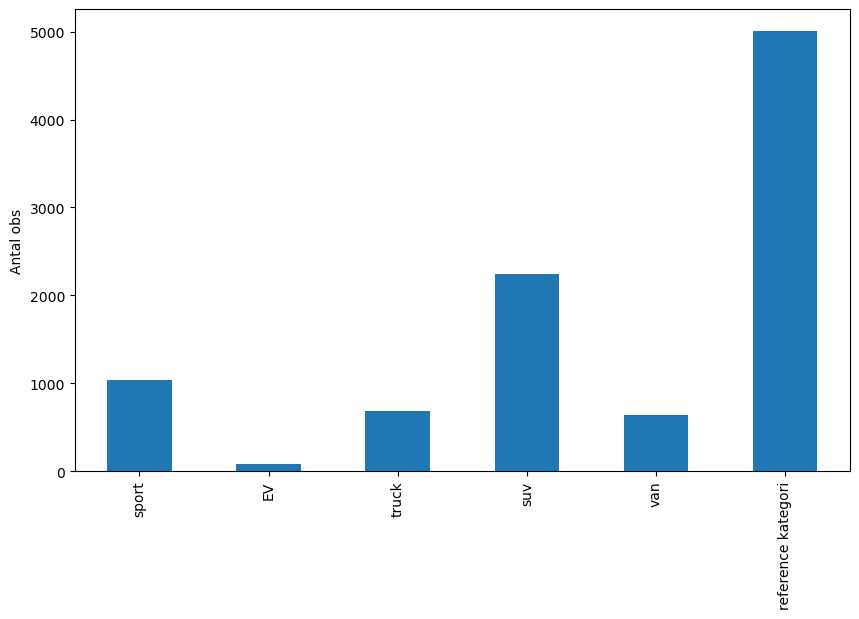

In [11]:
import matplotlib.pyplot as plt

# Beregn summen af dummyvariablerne og tilføj reference kategorien (sum må ikke være 0)
sums = X[D_type].sum(axis=0) # e.g. type, make, year
sums["reference kategori"]=X["const"].sum()-sums.sum()

# Lav en søjlediagram for summen 
sums.plot(kind='bar', figsize=(10, 6))

# Tilføj labels og titel
plt.ylabel('Antal obs')
plt.xticks(rotation=90)  # Drej x-axis labels for bedre læsbarhed

# Vis diagrammet
plt.show()

## Modelspecifikation for forbrugerens efterspørgsel

$$
\log\left(\frac{S_{jm}}{S_{0m}}\right) = \beta \mathbf{x}_{jm} - \alpha p_{jm} + \xi_{jm}
$$

hvor:
- $m$ refererer til **markedet** (her **året**).
- $S_{jm}$: Markedsandel af produkt $j$ i marked $m$.
- $S_{0m}$: Markedsandel for det "outside good" (ingen bilkøb) i marked $m$.
- $\mathbf{x}_{jm}$: Observerbare produktkarakteristika.
- $p_{jm}$: Pris for produkt $j$ i marked $m$.
- $\xi_{jm}$: Uobserverbare produktkarakteristika.

Vi estimerer fem versioner af følgende model, som adskiller sig ved hvordan $\xi_{jm}$ approximeres

#### Model 1: Baseline specifikation med kun priser ($p_{jm}$):
$$
\log\left(\frac{S_{jm}}{S_{0m}}\right) = \beta_0 + \beta_{\text{price}} p_{jm} + \epsilon_{jm}
$$

#### Model 2: Priser og produktkarakteristika ($\mathbf{x}_{jm}$):
$$
\log\left(\frac{S_{jm}}{S_{0m}}\right) = \beta_0 + \beta_{\text{price}} p_{jm} + \sum \beta_k \mathbf{x}_{jm,k} + \epsilon_{jm}
$$

#### Model 3: Tilføjer dummies for biltyper (sport, EV, truck, SUV, van):
$$
\log\left(\frac{S_{jm}}{S_{0m}}\right) = \beta_0 + \beta_{\text{price}} p_{jm} + \sum \beta_k \mathbf{x}_{jm,k} + \sum \delta_t D_{\text{type}, m} + \epsilon_{jm}
$$

#### Model 4: Tilføjer årsdummies for at kontrollere for markedsvirkninger:
$$
\log\left(\frac{S_{jm}}{S_{0m}}\right) = \beta_0 + \beta_{\text{price}} p_{jm} + \sum \beta_k \mathbf{x}_{jm,k} + \sum \delta_t D_{\text{type}, m} + \sum \gamma_y D_{\text{year}, m} + \epsilon_{jm}
$$

#### Model 5: Fuldspecifikation med bilmærke-dummies (fixed effects for mærker):
$$
\log\left(\frac{S_{jm}}{S_{0m}}\right) = \beta_0 + \beta_{\text{price}} p_{jm} + \sum \beta_k \mathbf{x}_{jm,k} + \sum \delta_t D_{\text{type}, m} + \sum \gamma_y D_{\text{year}, m} + \sum \eta_m D_{\text{make}, m} + \epsilon_{jm}
$$

**Bemærk**: I denne opsætning svarer marked $m$ til året ($m = t$).

### Estimate model

In [12]:
        
m1 = mlr.ols(X[['const','prices']], X["dlogS"] )
m2 = mlr.ols(X[['const','prices'] + Xvar], X["dlogS"] )
m3 = mlr.ols(X[['const','prices'] + Xvar + D_type], X["dlogS"] )
m4 = mlr.ols(X[['const','prices'] + Xvar + D_type + D_year], X["dlogS"] )
m5 = mlr.ols(X[['const','prices'] + Xvar + D_type + D_year + D_make], X["dlogS"] )

mlr.summary([m1,m2,m3, m4, m5])


                      Model 1    Model 2    Model 3    Model 4    Model 5
Dependent variable      dlogS      dlogS      dlogS      dlogS      dlogS
             const    -5.9072   -14.3689   -14.3617   -25.3636   -15.8109
                     (0.0439)   (1.4477)   (1.6224)   (1.6575)   (1.7222)
            prices    -0.3733    -0.2031    -0.1787    -0.2982    -0.3367
                     (0.0110)   (0.0139)   (0.0139)   (0.0142)   (0.0174)
        log_height               -0.8774    -2.2726    -1.2168    -0.8707
                                (0.2081)   (0.2679)   (0.2632)   (0.2550)
     log_footprint                3.0629     4.0413     2.9136     2.0209
                                (0.2058)   (0.2238)   (0.2203)   (0.2279)
            log_hp               -1.2029    -1.2179     0.4285     0.3750
                                (0.0657)   (0.0663)   (0.0994)   (0.0950)
           log_mpg               -1.3059    -1.2027     0.3280    -0.1240
                                (0.077

## Fixed Effects og Within Transformation - alternativ til dummies

Vi antager, at en del af $\xi_{mj}$, det uobserverbare led i vores model, er specifikt for bilproducenten (mærket). Dette giver anledning til følgende lineære model:

$$
\log\left(\frac{S_{mj}}{S_{m0}}\right) = \beta \mathbf{x}_{mj} - \alpha p_{mj} + \xi_{mj}
$$

### Opsplitning af $\xi_{mj}$:
Lad $\xi_{mj} = \gamma_{\text{make}} + \tilde{\xi}_{mj}$, hvor $\gamma_{\text{make}}$ repræsenterer fixed effect for producenten (mærket), og $\tilde{\xi}_{mj}$ er den resterende fejlled.

Dermed bliver modellen:
$$
\log\left(\frac{S_{mj}}{S_{m0}}\right) = \beta \mathbf{x}_{mj} - \alpha p_{mj} + \gamma_{\text{make}} + \tilde{\xi}_{mj}
$$

### Anvendelse af Within Transformation:
For at eliminere fixed effect $\gamma_{\text{make}}$, de-meaner vi ligningen ved at trække gennemsnittet inden for hver producentgruppe fra:

$$
\log\left(\frac{S_{mj}}{S_{m0}}\right) - \overline{\log\left(\frac{S_{mj}}{S_{m0}}\right)} = \beta \left(\mathbf{x}_{mj} - \overline{\mathbf{x}_{mj}}\right) - \alpha \left(p_{mj} - \overline{p_{mj}}\right) + \left(\tilde{\xi}_{mj} - \overline{\tilde{\xi}_{mj}}\right)
$$

Da $\gamma_{\text{make}}$ er konstant inden for hver gruppe, forsvinder det ved transformationen:
$$
\log\left(\frac{S_{mj}}{S_{m0}}\right)^{\text{demeaned}} = \beta \mathbf{x}_{mj}^{\text{demeaned}} - \alpha p_{mj}^{\text{demeaned}} + \tilde{\xi}_{mj}^{\text{demeaned}}
$$

### Bemærk:
- **Fixed effects elimineres**, så vi kan estimere $\alpha$ og $\beta$ ved at bruge variationen inden for hver producent.
- Vi får **samme parametre** som ved inkludering af producent-dummies i modellen.
- **Demeaning** er en praktisk metode til at undgå at inkludere mange dummies i modellen.
- Dette er en anvendelse af **Frisch-Waugh-teoremet**, som viser, at vi kan regressere de-meanet $y$ på de-meanet $x$ og få de samme resultater som med dummies.

In [13]:
# Function to perform within transformation (demean within groups)
def within_transform(df, columns, category):
    # Create a copy of the dataframe to avoid modifying the original
    df_transformed = df.copy()
    
    # Loop through each column that requires transformation
    for col in columns:
        # Compute group means based on the categorized variable
        group_means = df.groupby(category)[col].transform('mean')
        
        # Subtract group means from the column values (demeaning within groups)
        df_transformed[col] = df[col] - group_means
    
    return df_transformed

Zvars= ['prices'] + Xvar + D_type + D_year; 
Xt = within_transform(X, Zvars + ['dlogS'], 'make')

m_ols = mlr.ols(X[['const'] + Zvars + D_make], X["dlogS"] )
m_fe = mlr.ols(Xt[Zvars], Xt["dlogS"] )

mlr.summary([m_ols, m_fe])


                      Model 1    Model 2
Dependent variable      dlogS      dlogS
            prices    -0.3367    -0.3367
                     (0.0174)   (0.0173)
        log_height    -0.8707    -0.8707
                     (0.2550)   (0.2542)
     log_footprint     2.0209     2.0209
                     (0.2279)   (0.2271)
            log_hp     0.3750     0.3750
                     (0.0950)   (0.0947)
           log_mpg    -0.1240    -0.1240
                     (0.1045)   (0.1041)
    log_curbweight    -0.9774    -0.9774
                     (0.2024)   (0.2017)
  log_number_trims     1.1894     1.1894
                     (0.0174)   (0.0173)
       releaseYear    -0.4066    -0.4066
                     (0.0500)   (0.0498)
  yearsSinceDesign    -0.1103    -0.1103
                     (0.0048)   (0.0047)
             sport    -0.5421    -0.5421
                     (0.0528)   (0.0526)
                EV    -0.9817    -0.9817
                     (0.1672)   (0.1666)
             tru

## Endogenitetsproblemet: 
#### Er MLR.4 opfyldt? $$E[\xi_{jm}|\mathbf{x}_{jm},p_{jm}]=0$$

**Hvad er endogenitet?**
- Endogenitet opstår, når $[\xi_{jm}|\mathbf{x}_{jm},p_{jm}] \neq 0$
- I vores tilfælde kan prisen ($p_{mj}$) være endogen, hvis uobserverbare faktorer, der påvirker efterspørgslen ($\xi_{mj}$), også påvirker prisen.

**Eksempel:**
- **Uobserverede karakteristika ($\xi_{mj}$):** Ting som kvalitet, mærke-image, eller økonomiske stød kan påvirke både efterspørgslen og prisen.
- Dette betyder, at når vi forsøger at estimere effekten af prisen på markedsandele, vil vi fejlagtigt tilskrive en del af effekten fra $\xi_{mj}$ til prisen.

**Konsekvens:**
- Hvis der er endogenitet, vil OLS estimaterne af $\alpha$ (pris-effekten) være biased, da de uobserverbare faktorer ikke er uafhængige af prisen.

### Beregn egenpriselasticitet

For at beregne egenpriselasticiteten $\varepsilon_j$ bruger vi følgende udtryk baseret på estimaterne fra vores logit-model:

$$
\varepsilon_{mj} \equiv \frac{dS_{mj}/S_{mj}}{dp_{mj}/p_{mj}} = \alpha \cdot p_{mj} \cdot (1 - S_{mj})
$$

- Model 1: Baseline specifikation med kun priser ($p_{jm}$):
- Model 2: Priser og produktkarakteristika ($\mathbf{x}_{jm}$):
- Model 3: Tilføjer dummies for biltyper (sport, EV, truck, SUV, van):
- Model 4: Tilføjer årsdummies for at kontrollere for markedsvirkninger:
- Model 5: Fuldspecifikation med bilmærke-dummies (fixed effects for mærker):

In [14]:
for i, model in enumerate([m1,m2,m3,m4,m5]):
    idx=model['lbl_X'].index('prices');
    alpha = model["beta_hat"][idx]
    X["elasticity"] = df.apply(lambda x: alpha * x["prices"] * (1 - x["Smj"]) , axis=1)
    print(f"Gennemsnitlig egenpris elasticitet for model {i+1} = {X['elasticity'].mean()}")

Gennemsnitlig egenpris elasticitet for model 1 = [-1.34396925]
Gennemsnitlig egenpris elasticitet for model 2 = [-0.7311627]
Gennemsnitlig egenpris elasticitet for model 3 = [-0.64355756]
Gennemsnitlig egenpris elasticitet for model 4 = [-1.0736847]
Gennemsnitlig egenpris elasticitet for model 5 = [-1.21219317]


## Hvordan kan dummies reducere endogenitetsproblemet?

**Inkludering af dummies kan hjælpe ved at:**
- Kontrollere for **faste uobserverbare faktorer**, som er konstante over tid eller mellem mærker:
    - **Års-dummies:** Fanger makroøkonomiske forhold som inflation eller recessioner, der påvirker både pris og efterspørgsel i et givet år.
    - **Bilmærke-dummies:** Tager højde for bilspecifikke faktorer som brand image eller kvalitet, som kan være konstante over tid men variere mellem bilmærker.

**Hvordan dummies afhjælper endogenitet:**
- Dummies fjerner noget af den uobserverede variation, som påvirker både priser og markedsandele.
- Derved får vi renere estimater af effekten af prisen, da en del af den fælles variation mellem pris og $\xi_{mj}$ fjernes.

## Hvorfor er IVs nødvendige for at fjerne endogenitet helt?

**Dummies har begrænsninger:**
- Selvom dummies hjælper med at kontrollere for faste eller tidsvarierende uobserverede faktorer, kan de ikke fange **variation inden for en kategori**.
    - Eksempel: Selv med bilmærke-dummies kan vi ikke kontrollere for variation i efterspørgsel inden for BMW-biler (som fx model-specifikke udsving).
- Der kan stadig være en korrelation mellem priser og uobserverbare faktorer inden for hver kategori.

**Løsningen: Instrumentvariable (IVs):**
- IVs bruges til at eliminere endogenitet, når vi har variabler, der er korrelerede med prisen, men ikke direkte med fejlleddet ($u$).
    - **Eksempel:** Produktionsomkostninger, eller inputpriser, der påvirker prisen, men ikke efterspørgslen direkte.
- Ved at bruge IVs kan vi isolere den eksogene variation i prisen, hvilket fører til unbiased estimater af pris-effekten.
- Vi ser på IV estimation i næste uge

## Kommentarer på resultaterne

**Resultaterne viser:**
- Uden dummies (model 1), er priselasticiteten meget høj (-1.34), hvilket tyder på, at der kan være betydelig endogenitet, hvor uobserverede faktorer påvirker både prisen og efterspørgslen.
- Når vi tilføjer flere dummies (model 2 til model 5), falder priselasticiteten gradvist, hvilket indikerer, at kontrollen for uobserverede faktorer gennem dummies afhjælper en del af endogeniteten.
    - I model 5 er elasticiteten -1.21, hvilket er mere plausibelt, men vi kan stadig ikke udelukke, at der er yderligere endogenitet.

**Begrænsning uden IVs:**
- Selvom dummies har reduceret noget af endogeniteten, kan vi ikke fjerne al endogenitet uden IVs. For at få fuldstændigt unbiased estimater af priselasticiteten, skal vi inkludere eksterne instrumenter.

## Diskussion af Endogenitetsproblemet

Priser er endogene, da de både kan afhænge af efterspørgsel og uobserverede faktorer, såsom produktets kvalitet, der også påvirker efterspørgslen. Hvis vi ikke kontrollerer for endogenitet, kan vores estimater for prisen ($\alpha$) blive biased.

### Hvordan kan dummies/fixed effects hjælpe?
- Ved at inkludere dummies for mærker og år, kan vi fange uobserverede faktorer, som kan variere mellem producenter og over tid.
- Det hjælper med at eliminere noget af den fælles variation i pris, men fjerner ikke nødvendigvis endogenitet fuldstændigt, især når den varierer inden for en given kategori (f.eks. mellem biler fra samme producent eller år).

### IV-løsning
For fuldstændigt at eliminere endogenitetsproblemet, skal vi bruge instrumentelle variable (IVs). 
I denne artikel bruger forfatterne **inputomkostninger og valutakurser** som instrumenter, da de påvirker priserne, men ikke direkte efterspørgslen. Dette fjerner den del af prisvariationen, der er forårsaget af endogenitet, og fører til mere pålidelige estimater for prisfølsomheden.

### Resultater og implikationer
- I vores modeller ser vi, at inklusionen af flere variable og dummies reducerer prisfølsomheden. Dette indikerer, at endogenitet påvirker vores grundlæggende estimater. 
- IV-metoden, som bruges i artiklen, giver et næste skridt for at fjerne endogenitetsbias og sikre mere præcise resultater.